In [1]:
# Full end-to-end script: dataset -> models -> training -> evaluation -> visualize -> save
import os, time, math, random
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


In [2]:
# Config
# ----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

BASE_PATH = "/kaggle/input/feta-challenge-2024-brain-segmentation/nnUNet_raw_data_base/nnUNet_raw_data/FETA_Challenge"
IMAGES_DIR = os.path.join(BASE_PATH, "imagesTr")
LABELS_DIR = os.path.join(BASE_PATH, "labelsTr")
assert os.path.exists(IMAGES_DIR) and os.path.exists(LABELS_DIR), "Adjust BASE_PATH to dataset location"

RESIZE = (128, 128)
BATCH_SIZE = 4
VIZ_BATCH = 4
EPOCHS = 5
BASE_FILTERS = 16
NUM_WORKERS = 2
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cuda


In [3]:
# Dataset: expand vol -> 2D slices
# ----------------------
class SlicedBrainDataset(Dataset):
    def __init__(self, images_dir, labels_dir, resize=(128,128)):
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])
        self.labels = sorted([f for f in os.listdir(labels_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])
        assert len(self.images) == len(self.labels), f"image/label mismatch: {len(self.images)} vs {len(self.labels)}"
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.resize = resize
        # transforms operate on PIL images
        self.transform_img = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.transform_mask = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.pairs = []
        for img_f, lbl_f in zip(self.images, self.labels):
            img_path = os.path.join(images_dir, img_f)
            lbl_path = os.path.join(labels_dir, lbl_f)
            vol = nib.load(img_path).get_fdata().astype(np.float32)
            lbl = nib.load(lbl_path).get_fdata().astype(np.float32)
            mn, mx = float(np.min(vol)), float(np.max(vol))
            if mx > mn:
                vol = (vol - mn) / (mx - mn)
            else:
                vol = np.zeros_like(vol, dtype=np.float32)
            # choose non-empty slices
            nz = [i for i in range(vol.shape[2]) if vol[:, :, i].sum() > 0]
            if not nz:
                nz = [vol.shape[2] // 2]
            for z in nz:
                img_slice = (vol[:, :, z] * 255.0).astype(np.uint8)
                mask_slice = (lbl[:, :, z] > 0).astype(np.uint8) * 255
                self.pairs.append((img_slice, mask_slice))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_arr, mask_arr = self.pairs[idx]
        img = Image.fromarray(img_arr).convert("L")
        mask = Image.fromarray(mask_arr).convert("L")
        img_t = self.transform_img(img)                      # float32 Tensor (1,H,W) in [0,1]
        mask_t = (self.transform_mask(mask) > 0.5).float()   # binary Tensor (1,H,W)
        return img_t, mask_t


In [4]:
# create dataset + loaders
dataset = SlicedBrainDataset(IMAGES_DIR, LABELS_DIR, resize=RESIZE)
print("Total 2D slices:", len(dataset))
assert len(dataset) > 0, "No slices found"

train_n = int(0.8 * len(dataset))
val_n = len(dataset) - train_n
train_ds, val_ds = random_split(dataset, [train_n, val_n])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
viz_loader = DataLoader(val_ds, batch_size=VIZ_BATCH, shuffle=False, num_workers=1, pin_memory=True)


Total 2D slices: 11910


In [5]:
# Models (UNet + MambaUNet)
# ----------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_filters=16):
        super().__init__()
        f = base_filters
        self.enc1 = DoubleConv(in_ch, f)
        self.enc2 = DoubleConv(f, f*2)
        self.enc3 = DoubleConv(f*2, f*4)
        self.enc4 = DoubleConv(f*4, f*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(f*8, f*16)
        self.up4 = nn.ConvTranspose2d(f*16, f*8, 2, stride=2); self.dec4 = DoubleConv(f*16, f*8)
        self.up3 = nn.ConvTranspose2d(f*8, f*4, 2, stride=2); self.dec3 = DoubleConv(f*8, f*4)
        self.up2 = nn.ConvTranspose2d(f*4, f*2, 2, stride=2); self.dec2 = DoubleConv(f*4, f*2)
        self.up1 = nn.ConvTranspose2d(f*2, f, 2, stride=2);   self.dec1 = DoubleConv(f*2, f)
        self.final = nn.Conv2d(f, out_ch, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

class MambaBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pw1 = nn.Conv2d(channels, channels, 1)
        self.dw  = nn.Conv2d(channels, channels, 3, padding=1, groups=channels)
        self.pw2 = nn.Conv2d(channels, channels, 1)
        self.norm = nn.BatchNorm2d(channels)
        self.act = nn.GELU()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, max(1, channels//8), 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(1, channels//8), channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        r = x
        x = self.pw1(x); x = self.dw(x); x = self.pw2(x)
        x = self.norm(x); x = self.act(x)
        x = x * self.se(x)
        return x + r

class MambaUNet(UNet):
    def __init__(self, in_ch=1, out_ch=1, base_filters=16):
        super().__init__(in_ch, out_ch, base_filters)
        f = base_filters
        self.enc1 = nn.Sequential(DoubleConv(in_ch, f), MambaBlock(f))
        self.enc2 = nn.Sequential(DoubleConv(f, f*2), MambaBlock(f*2))
        self.enc3 = nn.Sequential(DoubleConv(f*2, f*4), MambaBlock(f*4))
        self.enc4 = nn.Sequential(DoubleConv(f*4, f*8), MambaBlock(f*8))
        self.bottleneck = nn.Sequential(DoubleConv(f*8, f*16), MambaBlock(f*16))


In [6]:
# Losses, metrics, training/eval
# ----------------------
bce_with_logits = nn.BCEWithLogitsLoss()

def dice_loss_logits(preds, targets, eps=1e-6):
    probs = torch.sigmoid(preds)
    inter = (probs * targets).sum(dim=(1,2,3))
    union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    loss = 1 - (2 * inter + eps) / (union + eps)
    return loss.mean()

def dice_score_logits(preds, targets, eps=1e-6):
    probs = torch.sigmoid(preds)
    preds_bin = (probs > 0.5).float()
    inter = (preds_bin * targets).sum(dim=(1,2,3))
    union = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    score = (2 * inter + eps) / (union + eps)
    return score.mean().item()

def iou_logits(preds, targets, eps=1e-6):
    probs = torch.sigmoid(preds)
    preds_bin = (probs > 0.5).float()
    inter = (preds_bin * targets).sum(dim=(1,2,3))
    union = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
    return ((inter + eps) / (union + eps)).mean().item()

def train_one_epoch(model, loader, optim, device):
    model.train()
    running_loss = 0.0
    n = 0
    for imgs, masks in loader:
        # ensure tensors float and on same device as model
        imgs = imgs.to(device, dtype=torch.float32, non_blocking=True)
        masks = masks.to(device, dtype=torch.float32, non_blocking=True)
        masks = (masks > 0.5).float()
        preds = model(imgs)
        loss_bce = bce_with_logits(preds, masks)
        loss_dice = dice_loss_logits(preds, masks)
        loss = loss_bce + loss_dice
        optim.zero_grad()
        loss.backward()
        optim.step()
        running_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)
    return running_loss / n


In [7]:
def evaluate(model, loader, device):
    model.eval()
    total_bce = total_dice_loss = total_dice_score = total_iou = 0.0
    n = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device, dtype=torch.float32, non_blocking=True)
            masks = masks.to(device, dtype=torch.float32, non_blocking=True)
            masks = (masks > 0.5).float()
            preds = model(imgs)
            total_bce += bce_with_logits(preds, masks).item() * imgs.size(0)
            total_dice_loss += dice_loss_logits(preds, masks).item() * imgs.size(0)
            total_dice_score += dice_score_logits(preds, masks) * imgs.size(0)
            total_iou += iou_logits(preds, masks) * imgs.size(0)
            n += imgs.size(0)
    return total_bce / n, total_dice_loss / n, total_dice_score / n, total_iou / n

def measure_inference_memory(model, loader, device):
    model.eval()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
    start = time.time()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device, dtype=torch.float32)
            _ = model(imgs)
    if torch.cuda.is_available():
        torch.cuda.synchronize(device)
        peak = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    else:
        peak = 0.0
    elapsed = time.time() - start
    return elapsed, peak


In [8]:

# ----------------------
# Instantiate models and run training
# ----------------------
unet = UNet(in_ch=1, out_ch=1, base_filters=BASE_FILTERS).to(device)
mamba = MambaUNet(in_ch=1, out_ch=1, base_filters=BASE_FILTERS).to(device)

def run_training(model, name, epochs, lr=1e-4):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_bce": [], "val_dice_loss": [], "val_dice_score": [], "val_iou": []}
    for ep in range(epochs):
        t0 = time.time()
        train_loss = train_one_epoch(model, train_loader, optim, device)
        val_bce, val_dice_loss, val_dice_score, val_iou = evaluate(model, val_loader, device)
        history["train_loss"].append(train_loss)
        history["val_bce"].append(val_bce)
        history["val_dice_loss"].append(val_dice_loss)
        history["val_dice_score"].append(val_dice_score)
        history["val_iou"].append(val_iou)
        print(f"{name} epoch {ep+1}/{epochs} train_loss {train_loss:.4f} val_bce {val_bce:.4f} val_dice_loss {val_dice_loss:.4f} val_dice {val_dice_score:.4f} val_iou {val_iou:.4f} time {time.time()-t0:.1f}s")
    inf_time, peak = measure_inference_memory(model, val_loader, device)
    print(f"{name} inference_time {inf_time:.2f}s peak_gpu_mb {peak:.1f}")
    return model, history, inf_time, peak

print("Training UNet...")
unet_model, unet_hist, unet_time, unet_mem = run_training(unet, "UNet", EPOCHS)
# save
torch.save(unet_model.state_dict(), os.path.join(SAVE_DIR, "unet_feta.pth"))
print("Saved UNet to", os.path.join(SAVE_DIR, "unet_feta.pth"))

print("\nTraining MambaUNet...")
mamba_model, mamba_hist, mamba_time, mamba_mem = run_training(mamba, "MambaUNet", EPOCHS)
# save
torch.save(mamba_model.state_dict(), os.path.join(SAVE_DIR, "mamba_feta.pth"))
print("Saved MambaUNet to", os.path.join(SAVE_DIR, "mamba_feta.pth"))


Training UNet...
UNet epoch 1/5 train_loss 0.5420 val_bce 0.0851 val_dice_loss 0.2295 val_dice 0.9418 val_iou 0.9071 time 38.2s
UNet epoch 2/5 train_loss 0.1519 val_bce 0.0293 val_dice_loss 0.0780 val_dice 0.9565 val_iou 0.9302 time 36.8s
UNet epoch 3/5 train_loss 0.0717 val_bce 0.0170 val_dice_loss 0.0421 val_dice 0.9680 val_iou 0.9479 time 37.4s
UNet epoch 4/5 train_loss 0.0542 val_bce 0.0257 val_dice_loss 0.0488 val_dice 0.9610 val_iou 0.9365 time 38.1s
UNet epoch 5/5 train_loss 0.0496 val_bce 0.0457 val_dice_loss 0.0590 val_dice 0.9480 val_iou 0.9166 time 37.6s
UNet inference_time 3.59s peak_gpu_mb 67.3
Saved UNet to /kaggle/working/unet_feta.pth

Training MambaUNet...
MambaUNet epoch 1/5 train_loss 0.5297 val_bce 0.0672 val_dice_loss 0.1893 val_dice 0.9430 val_iou 0.9100 time 54.4s
MambaUNet epoch 2/5 train_loss 0.1451 val_bce 0.0500 val_dice_loss 0.1059 val_dice 0.9323 val_iou 0.8935 time 53.6s
MambaUNet epoch 3/5 train_loss 0.0721 val_bce 0.0199 val_dice_loss 0.0498 val_dice 0.9

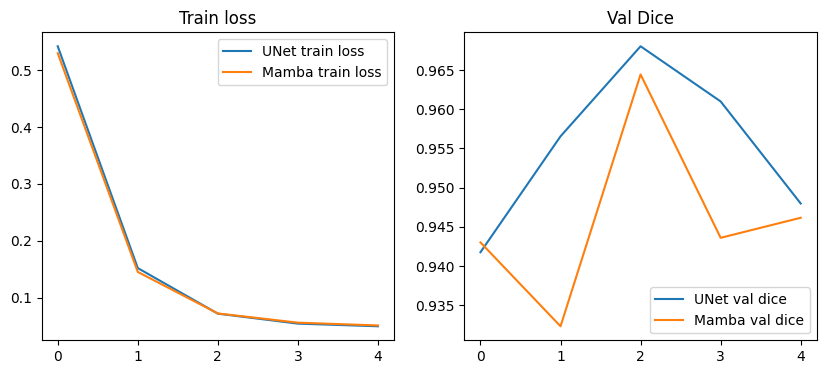

In [9]:
# ----------------------
# Plot training curves & compare
# ----------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(unet_hist["train_loss"], label="UNet train loss")
plt.plot(mamba_hist["train_loss"], label="Mamba train loss")
plt.legend(); plt.title("Train loss")
plt.subplot(1,2,2)
plt.plot(unet_hist["val_dice_score"], label="UNet val dice")
plt.plot(mamba_hist["val_dice_score"], label="Mamba val dice")
plt.legend(); plt.title("Val Dice")
plt.show()



UNet sample predictions:


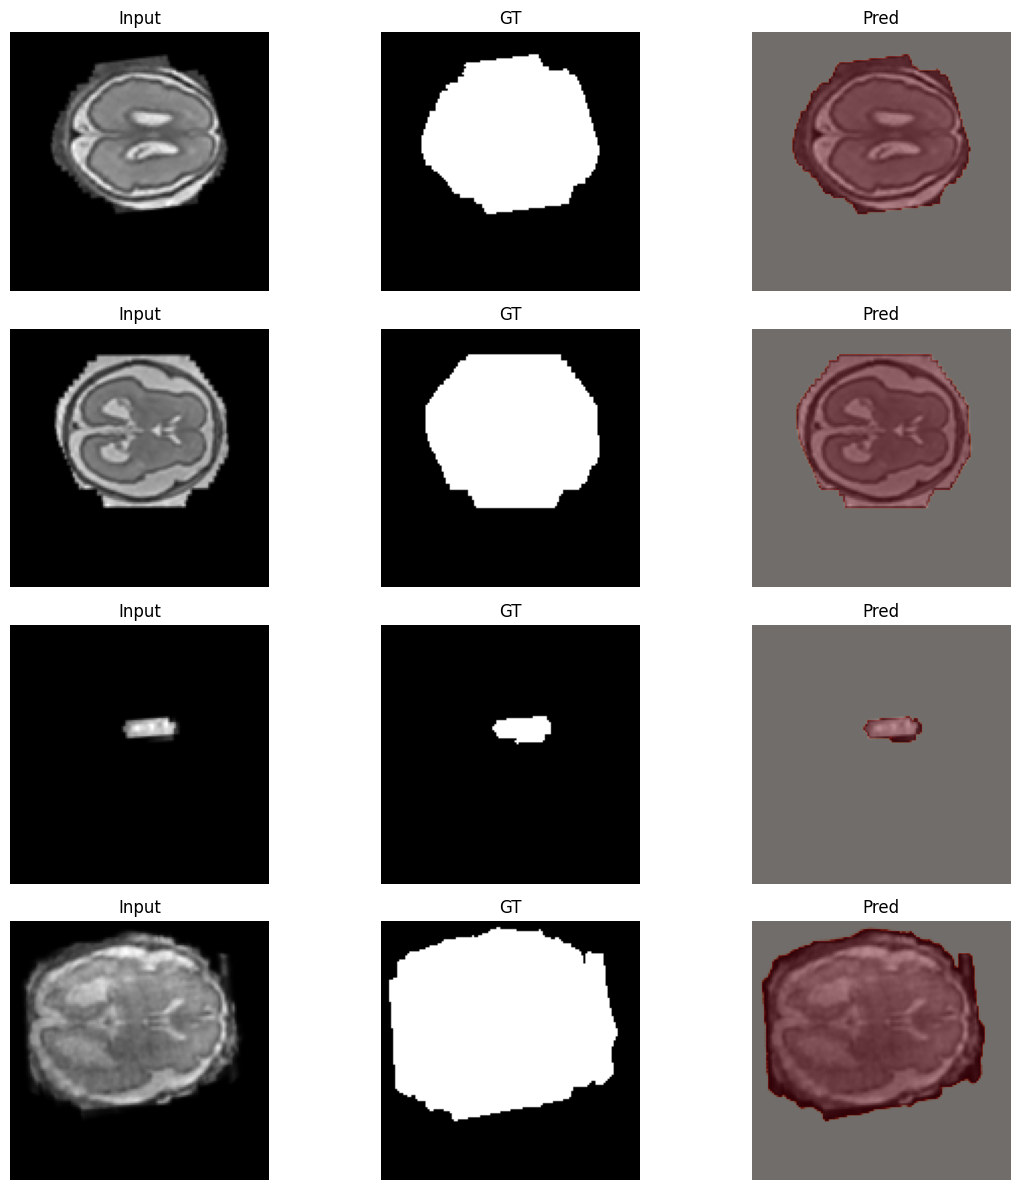


MambaUNet sample predictions:


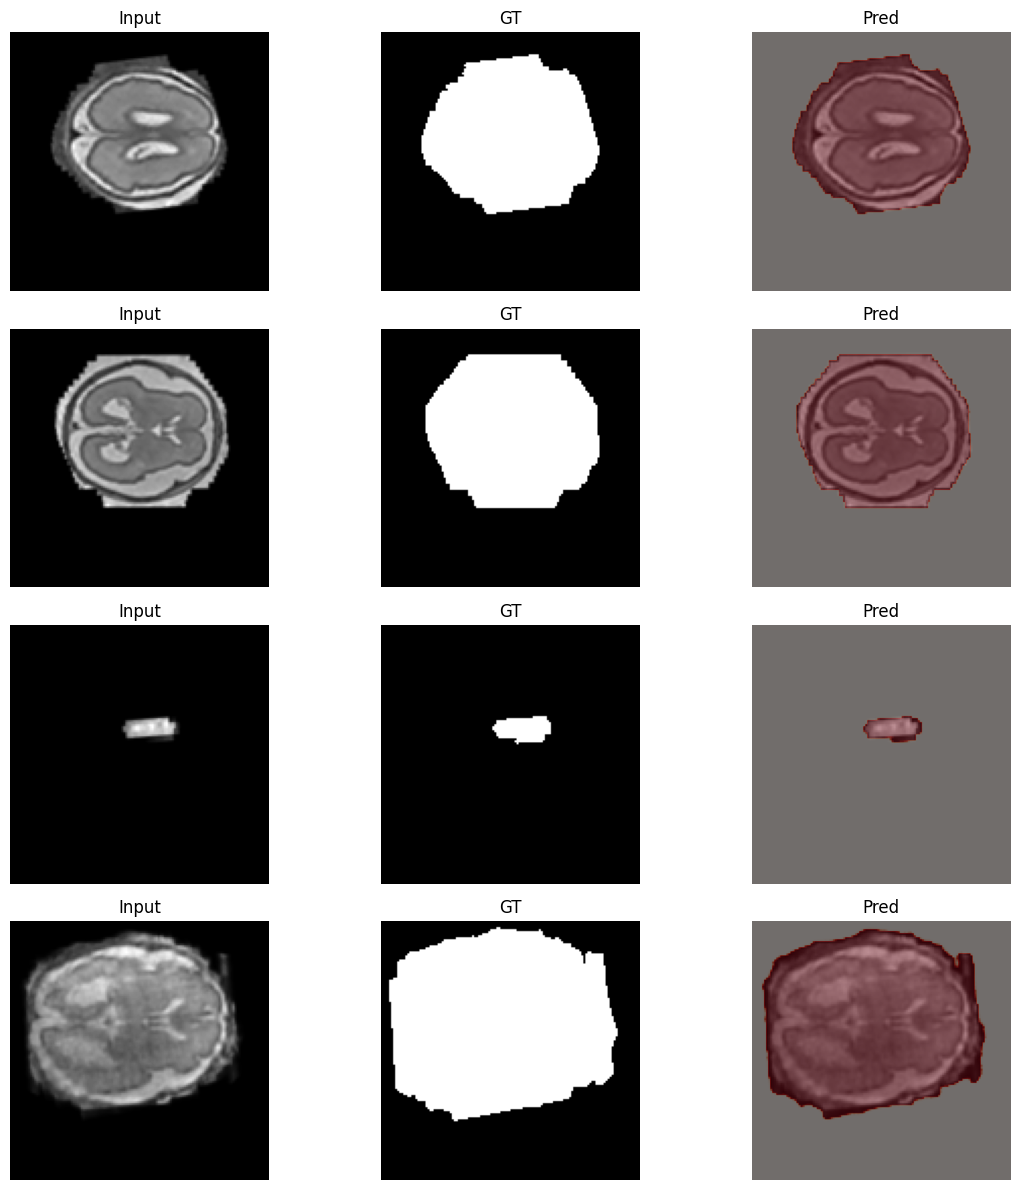

In [10]:
# ----------------------
# Device-safe prediction viewer
# ----------------------
def show_predictions(model, dataloader, num_samples=4):
    model.eval()
    device = next(model.parameters()).device
    collected = 0
    imgs_list = []; masks_list = []; preds_list = []
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            imgs_cpu = imgs.cpu().numpy(); masks_cpu = masks.cpu().numpy(); probs_cpu = probs.cpu().numpy()
            for i in range(imgs_cpu.shape[0]):
                imgs_list.append(imgs_cpu[i]); masks_list.append(masks_cpu[i]); preds_list.append(probs_cpu[i])
                collected += 1
                if collected >= num_samples: break
            if collected >= num_samples: break
    if collected == 0:
        print("No samples to visualize.")
        return
    plt.figure(figsize=(12, 3 * collected))
    for i in range(collected):
        img = imgs_list[i]; mask = masks_list[i]; pred = preds_list[i]
        img_plot = img[0] if (img.ndim==3 and img.shape[0]==1) else (img.transpose(1,2,0) if img.ndim==3 else img)
        mask_plot = mask[0] if (mask.ndim==3 and mask.shape[0]==1) else mask.squeeze()
        pred_plot = pred[0] if (pred.ndim==3 and pred.shape[0]==1) else pred.squeeze()
        plt.subplot(collected, 3, i*3+1); plt.imshow(img_plot, cmap="gray"); plt.title("Input"); plt.axis("off")
        plt.subplot(collected, 3, i*3+2); plt.imshow(mask_plot, cmap="gray"); plt.title("GT"); plt.axis("off")
        plt.subplot(collected, 3, i*3+3); plt.imshow(img_plot, cmap="gray"); plt.imshow(pred_plot, cmap="Reds", alpha=0.45); plt.title("Pred"); plt.axis("off")
    plt.tight_layout(); plt.show()

print("\nUNet sample predictions:")
show_predictions(unet_model, viz_loader, num_samples=4)
print("\nMambaUNet sample predictions:")
show_predictions(mamba_model, viz_loader, num_samples=4)



Visualize MambaUNet activations (enc1, bottleneck, dec1):
Module name sample: ['', 'enc1', 'enc1.0', 'enc1.0.net', 'enc1.0.net.0', 'enc1.0.net.1', 'enc1.0.net.2', 'enc1.0.net.3', 'enc1.0.net.4', 'enc1.0.net.5', 'enc1.1', 'enc1.1.pw1', 'enc1.1.dw', 'enc1.1.pw2', 'enc1.1.norm', 'enc1.1.act', 'enc1.1.se', 'enc1.1.se.0', 'enc1.1.se.1', 'enc1.1.se.2', 'enc1.1.se.3', 'enc1.1.se.4', 'enc2', 'enc2.0', 'enc2.0.net', 'enc2.0.net.0', 'enc2.0.net.1', 'enc2.0.net.2', 'enc2.0.net.3', 'enc2.0.net.4', 'enc2.0.net.5', 'enc2.1', 'enc2.1.pw1', 'enc2.1.dw', 'enc2.1.pw2', 'enc2.1.norm', 'enc2.1.act', 'enc2.1.se', 'enc2.1.se.0', 'enc2.1.se.1', 'enc2.1.se.2', 'enc2.1.se.3', 'enc2.1.se.4', 'enc3', 'enc3.0', 'enc3.0.net', 'enc3.0.net.0', 'enc3.0.net.1', 'enc3.0.net.2', 'enc3.0.net.3', 'enc3.0.net.4', 'enc3.0.net.5', 'enc3.1', 'enc3.1.pw1', 'enc3.1.dw', 'enc3.1.pw2', 'enc3.1.norm', 'enc3.1.act', 'enc3.1.se', 'enc3.1.se.0', 'enc3.1.se.1', 'enc3.1.se.2', 'enc3.1.se.3', 'enc3.1.se.4', 'enc4', 'enc4.0', 'enc4.0.ne

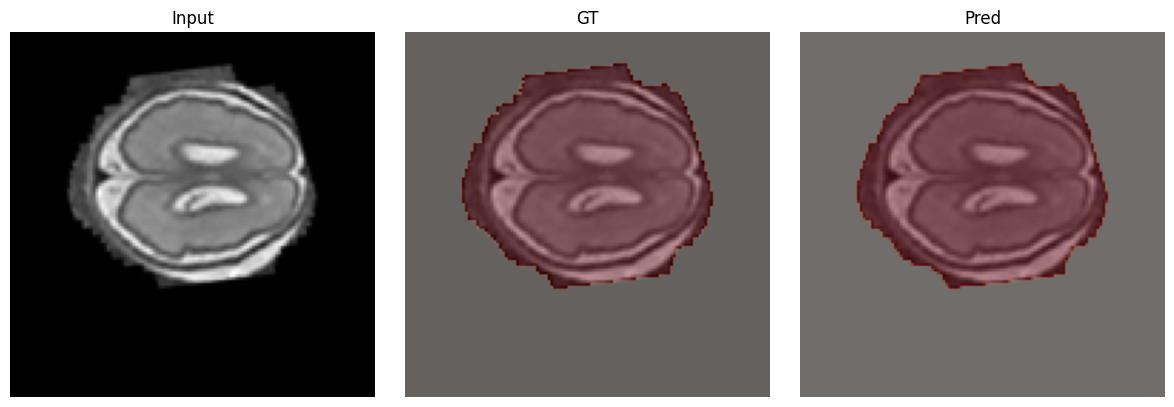

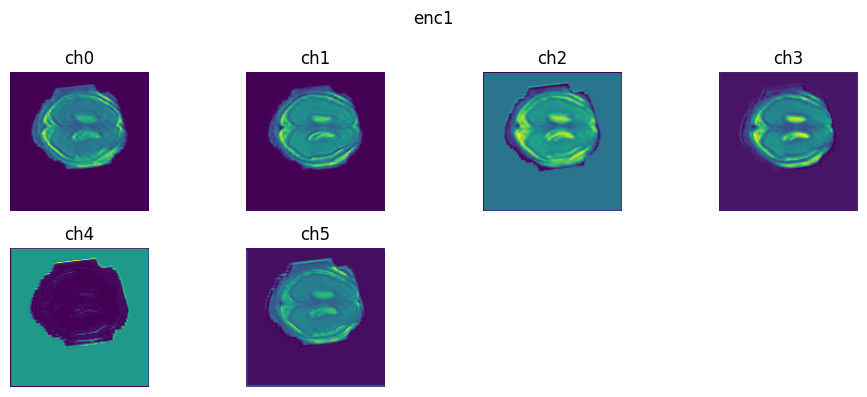

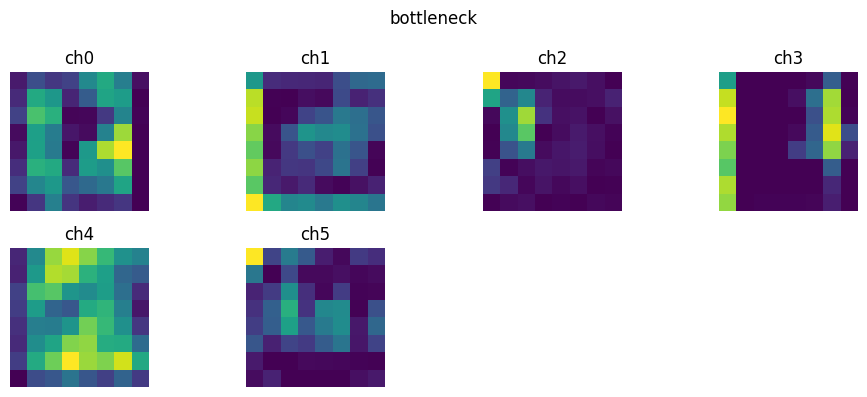

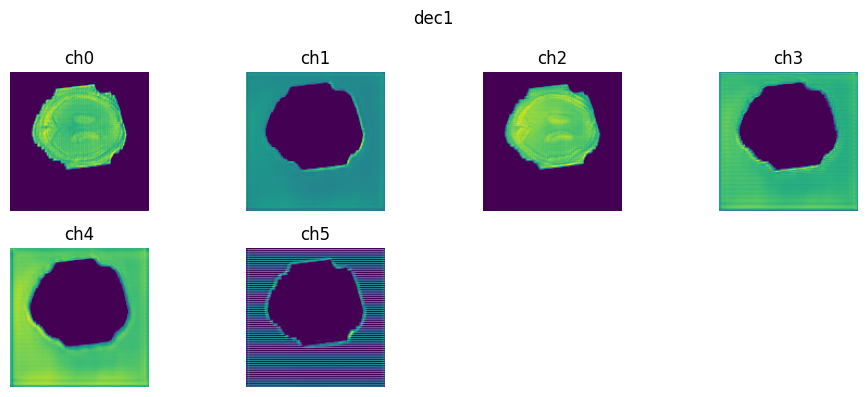

In [13]:
# --- Fixed Activation visualization cell for MambaUNet ---

def extract_activations_by_names(model, x, layer_names):
    model.eval()
    activations = {}
    handles = []
    named = dict(model.named_modules())
    for lname in layer_names:
        if lname not in named:
            raise KeyError(f"Layer '{lname}' not found. Sample names: {list(named.keys())[:80]}")
        def _mk(name):
            def hook(mod, inp, out):
                # store CPU copy
                activations[name] = out.detach().cpu()
            return hook
        handles.append(named[lname].register_forward_hook(_mk(lname)))
    with torch.no_grad():
        _ = model(x)
    for h in handles: h.remove()
    return activations

def show_feature_grid(feat_tensor, title=None, max_maps=6):
    # feat_tensor expected shape: (B, C, H, W) on CPU
    if feat_tensor is None:
        print("No feature tensor provided")
        return
    feat = feat_tensor[0]  # C, H, W
    C = feat.shape[0]
    n = min(C, max_maps)
    cols = min(4, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*2.4, rows*2.0))
    for i in range(n):
        m = feat[i].numpy()
        m = (m - m.min()) / (m.max() - m.min() + 1e-9)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(m, cmap="viridis")
        ax.axis("off")
        ax.set_title(f"ch{i}")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_mamba_activations(model, loader, layer_names=["enc1","bottleneck","dec1"], max_maps=6, num_images=1):
    # move model to its device and set eval
    dev = next(model.parameters()).device
    model.to(dev).eval()

    # get a batch (first)
    batch = next(iter(loader))
    imgs_cpu, masks_cpu = batch  # CPU tensors (B,1,H,W)
    # ensure we have enough images in the batch
    num_images = min(num_images, imgs_cpu.shape[0])

    # move the portion to device for forward
    imgs_dev = imgs_cpu[:num_images].to(dev, dtype=torch.float32)
    # extract activations (stored on CPU)
    acts = extract_activations_by_names(model, imgs_dev, layer_names)

    # get model predictions for the same inputs
    with torch.no_grad():
        logits = model(imgs_dev)
        probs_cpu = torch.sigmoid(logits).cpu().numpy()  # shape (num_images, 1, H, W)

    # iterate through requested images
    for i in range(num_images):
        # fetch CPU image and mask for plotting
        img_arr = imgs_cpu[i].numpy()   # shape (1,H,W)
        mask_arr = masks_cpu[i].numpy() # shape (1,H,W)
        pred_arr = probs_cpu[i]         # shape (1,H,W)

        # squeeze single-channel dims -> (H,W)
        if img_arr.ndim == 3 and img_arr.shape[0] == 1:
            img_plot = img_arr[0]
        else:
            img_plot = img_arr.transpose(1,2,0) if img_arr.ndim == 3 else img_arr

        mask_plot = mask_arr[0] if (mask_arr.ndim == 3 and mask_arr.shape[0] == 1) else mask_arr.squeeze()
        pred_plot = pred_arr[0] if (pred_arr.ndim == 3 and pred_arr.shape[0] == 1) else pred_arr.squeeze()

        # Plot input / GT / pred
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img_plot, cmap="gray"); plt.title("Input"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(img_plot, cmap="gray"); plt.imshow(mask_plot, cmap="Reds", alpha=0.4); plt.title("GT"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(img_plot, cmap="gray"); plt.imshow(pred_plot, cmap="Reds", alpha=0.45); plt.title("Pred"); plt.axis("off")
        plt.tight_layout(); plt.show()

        # show activations per requested layer
        for lname in layer_names:
            if lname in acts:
                show_feature_grid(acts[lname], title=f"{lname}", max_maps=max_maps)
            else:
                print(f"[info] No activation captured for '{lname}' (available sample names include: {list(dict(model.named_modules()).keys())[:40]})")

# run visualization
print("\nVisualize MambaUNet activations (enc1, bottleneck, dec1):")
print("Module name sample:", [n for n,_ in mamba_model.named_modules()][:120])
visualize_mamba_activations(mamba_model, viz_loader, layer_names=["enc1","bottleneck","dec1"], max_maps=6, num_images=1)


In [14]:

# ----------------------
# Final comparison summary
# ----------------------
from tabulate import tabulate
rows = [
    ["UNet", round(unet_hist["train_loss"][-1],4), round(unet_hist["val_dice_score"][-1],4), round(unet_time,3), round(unet_mem,1)],
    ["MambaUNet", round(mamba_hist["train_loss"][-1],4), round(mamba_hist["val_dice_score"][-1],4), round(mamba_time,3), round(mamba_mem,1)]
]
print(tabulate(rows, headers=["Model","Last train loss","Val Dice","Inference time (s)","Peak GPU MB"]))
print("Models saved to:", SAVE_DIR)


Model        Last train loss    Val Dice    Inference time (s)    Peak GPU MB
---------  -----------------  ----------  --------------------  -------------
UNet                  0.0496      0.948                  3.59            67.3
MambaUNet             0.051       0.9462                 5.127           78.6
Models saved to: /kaggle/working


# Trying with 100 epochs and stopping criteria

In [2]:
# ============================
# 1. Imports & Config
# ============================
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# ============================
# 2. Dataset
# ============================
class LGGDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        return img, mask

# ============================
# 3. Paths & Split
# ============================
data_dir = "/kaggle/input/feta-challenge-2024-brain-segmentation/nnUNet_raw_data_base/nnUNet_raw_data/FETA_Challenge"
image_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".tif") and "_mask" not in f])
mask_paths  = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_mask.tif")])

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=seed
)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = LGGDataset(train_imgs, train_masks, transform)
val_dataset   = LGGDataset(val_imgs, val_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ============================
# 4. Loss & Metrics
# ============================
def dice_coeff(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        smooth = 1e-6
        intersection = (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

# ============================
# 5. Models
# ============================
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        c = self.center(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(c), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

# MambaBlock (dummy example, replace with actual)
class MambaBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class AttentionMambaUNet(UNet):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__(in_channels, out_channels)
        self.center = nn.Sequential(
            MambaBlock(512),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.ReLU(inplace=True)
        )

# ============================
# 6. Training Loop with EarlyStopping
# ============================
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_score, model):
        if self.best_score is None or val_score > self.best_score:
            self.best_score = val_score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model, train_loader, val_loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    early_stopping = EarlyStopping(patience=5)

    history = {"train_loss": [], "val_loss": [], "val_dice": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = bce_loss(preds, masks) + dice_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                val_loss += (bce_loss(preds, masks) + dice_loss(preds, masks)).item()
                val_dice += dice_coeff(preds, masks).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)

        print(f"Epoch {epoch+1}/{epochs} - TLoss: {train_loss:.4f} VLoss: {val_loss:.4f} VDice: {val_dice:.4f}")

        early_stopping(val_dice, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(early_stopping.best_model_wts)
    return model, history, early_stopping.best_score

# ============================
# 7. Train & Compare
# ============================
unet = UNet().to(device)
mamba_unet = AttentionMambaUNet().to(device)

results = {}

for name, model in [("U-Net", unet), ("Attention Mamba U-Net", mamba_unet)]:
    start = time.time()
    best_model, history, best_dice = train_model(model, train_loader, val_loader, epochs=50)
    inf_start = time.time()
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        _ = best_model(imgs)
        break
    inf_time = (time.time() - inf_start) / len(imgs)

    results[name] = {
        "Last Val Loss": history["val_loss"][-1],
        "Best Val Dice": best_dice,
        "Inference Time/sample (s)": inf_time
    }

# ============================
# 8. Results Table
# ============================
df = pd.DataFrame(results).T
print(df)

# ============================
# 9. Side-by-side predictions
# ============================
def visualize_side_by_side(models, dataloader, num_samples=3):
    imgs, masks = next(iter(dataloader))
    imgs, masks = imgs.to(device), masks.to(device)

    preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = torch.sigmoid(model(imgs)) > 0.5
            preds.append(pred.cpu())

    plt.figure(figsize=(12, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(num_samples, len(models) + 2, i*(len(models)+2)+1)
        plt.imshow(imgs[i].cpu().permute(1,2,0))
        plt.axis("off")
        plt.title("Image")

        plt.subplot(num_samples, len(models) + 2, i*(len(models)+2)+2)
        plt.imshow(masks[i].cpu().squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("GT")

        for j, pred in enumerate(preds):
            plt.subplot(num_samples, len(models) + 2, i*(len(models)+2)+3+j)
            plt.imshow(pred[i].squeeze(), cmap="gray")
            plt.axis("off")
            plt.title(list(results.keys())[j])
    plt.tight_layout()
    plt.show()

visualize_side_by_side([unet, mamba_unet], val_loader)


Using device: cuda


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.